<a href="https://colab.research.google.com/github/anik314159/Hate-Alert-Urdu-Sentiment-Analysis-project-/blob/main/Urdu_Hate_Alert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:

if torch.cuda.is_available():
  device = torch.device("cuda")

else:
  device = torch.device("cpu")


In [ ]:
from google.colab import drive
drive.mount("/content/drive")
train_Data = pd.read_csv("/content/drive/MyDrive/Urdu_hate/train_set_taskA - train_set_Fire2022.csv")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_Data

,anger,disgust,fear,sadness,surprise,happiness,neutral,Sentences
0,0,0,0,1,1,0,0,محبت کے پردے میں نفرت کرنےوالو
1,0,0,0,0,0,1,0,حامد میر کی خوشی کے لئے اس کا ذمہ دار حکومت ہو...
2,0,0,0,0,0,0,1,اس نئے سال کی شام، ایک سپاہی قاتل (لارنس Fishb...
3,0,0,0,0,0,0,1,کچھ اس طرح سے ایک فلم کے لئے جا سکتے ہیں لیکن ...
4,0,0,0,0,0,0,1,"رون ہاورڈ اور اس کے ""ایڈیٹرز"" صرف اتنا کرنا ....."
...,...,...,...,...,...,...,...,...
7795,0,0,0,0,0,0,1,آپ کس طرح نوجوان برطانوی اداکار کی اس قابل احت...
7796,0,0,0,0,0,0,1,میں نے امریکہ کے کنفیڈریشن امریکہ میں ورجینیا ...
7797,0,0,0,0,0,1,0,سورۃ نمبر النساء آیت نمبر جب تم سفر پر جا رہے ...
7798,0,0,1,0,0,0,0,رونا یہ نہیں کہ حالات خراب ہیں اوراس بیماری نے...


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 29.0 MB/s 
     |████████████████████████████████| 6.6 MB 55.3 MB/s 
     |████████████████████████████████| 120 kB 58.4 MB/s 


In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
text = " Hi my name is Anik "
encodings = tokenizer.encode_plus(text, add_special_tokens = True,
                                  max_length=256,
                                  padding = 'max_length',
                                  truncation = True,
                                  return_attention_mask = True,
                                  return_tensors = 'pt')

target_list = ['anger','disgust','fear','sadness','surprise','happiness','neutral']

In [ ]:
encodings['token_type_ids']


tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
  def __init__(self,df,tokenizer,max_len):
    self.df = df;
    self.tokenizer = tokenizer
    self.max_len = max_len
    self.title = self.df['Sentences']
    self.targets = self.df[target_list].values

  def __len__(self):
    return len(self.title)

  def __getitem__(self,index):
    text = (self.title.iloc[index])
    
    text = " ".join(text.split()) #return to this function 

    inputs = self.tokenizer.encode_plus(text,add_special_tokens = True,
                                  max_length=self.max_len,
                                  padding = 'max_length',
                                  return_token_type_ids = True,
                                  truncation = True,
                                  return_attention_mask = True,
                                  return_tensors = 'pt')
    
    return {
        'input_ids' : inputs['input_ids'].flatten(),
        'attention_mask' : inputs['attention_mask'].flatten(),
        'token_type_ids' : inputs['token_type_ids'].flatten(),
        'targets': torch.FloatTensor(self.targets[index])
    }







In [ ]:
train_df , val_df = train_test_split(train_Data,test_size = 0.2, random_state = 2020)

#X_train , X_val = train_test_split(train_Data['Sentences'] , test_size = 0.2,random_state = 2020)
#y_df = pd.DataFrame(y_train , columns = ['Emotion'])
#y_train , y_val = train_test_split(y_df , test_size = 0.2,random_state = 2020)



In [ ]:
train_dataset = CustomDataset(train_df,tokenizer,256)
val_dataset = CustomDataset(val_df,tokenizer,256)


train_df

,anger,disgust,fear,sadness,surprise,happiness,neutral,Sentences
5235,0,0,0,1,1,0,0,سنبھلا تو حیرت ہوئی فرشتوں کو بہکا تو گناہ سر ...
3183,1,0,0,0,0,0,0,ساتھی قطعاً اپنے دشمن کو خوشی کا موقع نہ دے من...
2949,0,1,0,1,0,0,0,دُنیا کرونا وائرس سے ڈر رہی ہے پاکستانیوں نے ک...
1779,0,0,0,0,1,0,0,ویسے حیرت کی بات ہے انسان یہ ماننے کو تیار ہے ...
662,0,0,0,0,0,0,1,میں 10. کے اس پانچ باہر تمام پانچ نمبروں ہینڈر...
...,...,...,...,...,...,...,...,...
3779,0,0,0,0,0,0,0,جس سے نفرت کرتے ہو تاکہ اس کی نفرت کی بنا پر خ...
6774,0,0,0,0,0,1,0,نظم● کرونا وائرس کرونا ہم نے تیرا کیا بگاڑا کر...
7491,1,1,0,1,0,0,0,کمال ہے یہ تو مجھے بھی بلاک کر دیا اب چک کیا ہ...
4488,0,0,0,1,1,0,0,کیوں نہ حیرت ہو کہ بغض و کینہ و رنج و ملالہم ک...


In [ ]:
from torch.utils.data import TensorDataset , RandomSampler ,SequentialSampler ,DataLoader
#train_sampler = RandomSampler(train_dataset)
#val_sampler = SequentialSampler(val_dataset)
#test_sampler = SequentialSampler(test_data)


train_data_loader = torch.utils.data.DataLoader( train_dataset , shuffle = True  , batch_size = 16,num_workers =2 )
val_data_loader = torch.utils.data.DataLoader(val_dataset , shuffle =True , batch_size = 16,num_workers=2)

print(device)


cuda


In [ ]:
import shutil
import sys

def load_checkpoint(check_point_fpath,model,optimizer):
  checkpoint = torch.load(check_point_fpath)
  model.load_state_dict(checkpoint['step'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  valid_loss_min = checkpoint['valid_loss_min']

  return model,optimizer,checkpoint['epoch'],valid_loss_min



def save_checkpoint(state , is_best ,checkpoint_path,best_model_path):
  f_path = checkpoint_path
  torch.save(state,f_path)

  if is_best:
    best_fpath = best_model_path
    shutil.copyfile(f_path,best_fpath)

In [ ]:
from transformers import BertModel

import torch.nn as nn
class BERTClass(torch.nn.Module):
  def __init__(self):
    super(BERTClass,self).__init__()
    self.bert_model = BertModel.from_pretrained('bert-base-multilingual-cased' , return_dict = True)
    self.dropout = nn.Dropout(0.3)
    self.linear = nn.Linear(768,7)


  def forward(self,input_ids,attention_mask,token_type_ids):
    output = self.bert_model(input_ids,attention_mask,token_type_ids)
    output_dropout = self.dropout(output.pooler_output)
    output = self.linear(output_dropout)
    return output 

model = BERTClass()
model.to(device)



Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=T

In [ ]:
loss_model = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(params = model.parameters() , lr = 2e-5 ,eps = 1e-8)
#print(* train_data_loader)

def flattened_accuracy(pred,labels):
  pred_flat = np.argmax(pred,axis=1).flatten()
  labels_flat = labels.flatten()

  return np.sum(pred_flat==labels_flat) / len(labels_flat)




In [ ]:
import gc
gc.collect()
from transformers import get_linear_schedule_with_warmup
bestvalacc = 0
loss_val = []
def train_model (n_epoch , train_loader , val_loader ,model,optimizer ,checkpoint_path,best_model_path):
  val_loss_min  = np.inf
  for epoch in range(1,n_epoch+1):
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = len(train_data_loader)* n_epoch)
    train_loss = 0;
    valid_loss = 0;
    valid_acc = 0;
    nb_eval_steps = 0;
    model.train();
    print(" >>>>>>>>> Epoch {} : Training..".format(epoch))

    for batch_idx, data in enumerate(train_loader):
      
      if batch_idx % 40 == 0  and not batch_idx == 0:
        print('Batch : {} / {}'.format(batch_idx,len(train_loader)))

      ids = data['input_ids'].to(device , dtype = torch.long)
      mask = data['attention_mask'].to(device,dtype = torch.long)
      token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
      targets = data['targets'].to(device, dtype = torch.float)

      outputs = model(ids, mask, token_type_ids)

      
      loss = loss_model(outputs,targets)
      optimizer.zero_grad()
      loss.backward()      
      train_loss += loss.item()
      torch.nn.utils.clip_grad_norm(model.parameters(),1.0)
      optimizer.step()
      scheduler.step();

    avg_train_loss =  train_loss / len(train_data_loader)
    loss_val.append(avg_train_loss)

    print(" >>>>>>> Epoch {} / {}: Training end >...< average loss: {} ".format(epoch , n_epoch, avg_train_loss))

    print(" >>>>>>> Running validation ")

    model.eval();

    val_loss = []
    val_accuracy = []
    bestvalacc =0;
    for data in val_loader:
      in_id = data['input_ids'].to(device,dtype = torch.long)
      at_mask = data['attention_mask'].to(device,dtype = torch.long)
      t_t_id = data['token_type_ids'].to(device,dtype = torch.long)
      targets = data['targets'].to(device,dtype = torch.float)

      with torch.no_grad():
        outputs = model(in_id,at_mask,t_t_id)
      logits = outputs[0]

      loss = loss_model(outputs,targets)
      val_loss.append(loss.item())
    

      logits = logits.detach().cpu().numpy()
      label_ids = targets.cpu().numpy()

      temp_accuracy  = np.sum(logits.flatten() == label_ids.flatten()) / len(label_ids.flatten()) 
      val_accuracy.append(temp_accuracy)



    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)
    checkpoint_dict = {
        'epoch' : epoch,
        'valid_loss_min': val_loss,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }

    save_checkpoint(checkpoint_dict,False,checkpoint_path , best_model_path )
    if val_loss < val_loss_min:
      save_checkpoint(checkpoint_dict, True , checkpoint_path,best_model_path)
      print("validation decreased {} --> {} . Saving Model".format(val_loss_min,valid_loss))
      val_loss_min = valid_loss


    print(">>>>>>Epoch {} completed".format(epoch)) 
  return model 


  


ckpt_path = "/content/drive/MyDrive/Urdu_hate/curr_ckpt"
best_model_path = "/content/drive/MyDrive/Urdu_hate/best_model_path.pt"
trained_model = train_model (10 , train_data_loader , val_data_loader ,model,optimizer,ckpt_path,best_model_path)




    

 >>>>>>>>> Epoch 1 : Training..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Batch : 40 / 390
Batch : 80 / 390
Batch : 120 / 390
Batch : 160 / 390
Batch : 200 / 390
Batch : 240 / 390
Batch : 280 / 390
Batch : 320 / 390
Batch : 360 / 390
 >>>>>>> Epoch 1 / 10: Training end >...< average loss: 0.308911468852789 
 >>>>>>> Running validation 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


validation decreased inf --> 0 . Saving Model
>>>>>>Epoch 1 completed
 >>>>>>>>> Epoch 2 : Training..
Batch : 40 / 390
Batch : 80 / 390
Batch : 120 / 390
Batch : 160 / 390
Batch : 200 / 390
Batch : 240 / 390
Batch : 280 / 390
Batch : 320 / 390
Batch : 360 / 390
 >>>>>>> Epoch 2 / 10: Training end >...< average loss: 0.23561102837706224 
 >>>>>>> Running validation 
>>>>>>Epoch 2 completed
 >>>>>>>>> Epoch 3 : Training..
Batch : 40 / 390
Batch : 80 / 390
Batch : 120 / 390
Batch : 160 / 390
Batch : 200 / 390
Batch : 240 / 390
Batch : 280 / 390
Batch : 320 / 390
Batch : 360 / 390
 >>>>>>> Epoch 3 / 10: Training end >...< average loss: 0.20330769207615118 
 >>>>>>> Running validation 
>>>>>>Epoch 3 completed
 >>>>>>>>> Epoch 4 : Training..
Batch : 40 / 390
Batch : 80 / 390
Batch : 120 / 390
Batch : 160 / 390
Batch : 200 / 390
Batch : 240 / 390
Batch : 280 / 390
Batch : 320 / 390
Batch : 360 / 390
 >>>>>>> Epoch 4 / 10: Training end >...< average loss: 0.1783335319505288 
 >>>>>>> Running v

In [ ]:
print("")
print("Training Complete")


Training Complete


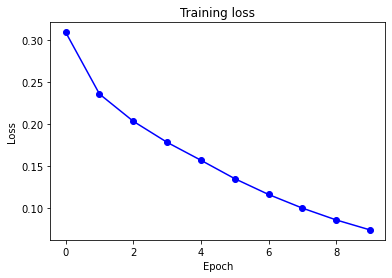

In [ ]:
import matplotlib.pyplot as plt


plt.plot(loss_val,'b-o')
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
class CustomDataset_test(torch.utils.data.Dataset):
  def __init__(self,df,tokenizer,max_len):
    self.df = df;
    self.tokenizer = tokenizer
    self.max_len = max_len
    self.title = self.df['Sentences']
    #self.targets = self.df[target_list].values

  def __len__(self):
    return len(self.title)

  def __getitem__(self,index):
    text = (self.title.iloc[index])
    
    text = " ".join(text.split()) #return to this function 

    inputs = self.tokenizer.encode_plus(text,add_special_tokens = True,
                                  max_length=self.max_len,
                                  padding = 'max_length',
                                  return_token_type_ids = True,
                                  truncation = True,
                                  return_attention_mask = True,
                                  return_tensors = 'pt')
    
    return {
        'input_ids' : inputs['input_ids'].flatten(),
        'attention_mask' : inputs['attention_mask'].flatten(),
        'token_type_ids' : inputs['token_type_ids'].flatten()        
    }

In [ ]:
test_Data = pd.read_csv("/content/drive/MyDrive/Urdu_hate/test_set_taskA_unlabelled - test_set_Fire2022_unlabelled.csv")

model.eval()

predictions , true_labels = [] , []
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

test_dataset = CustomDataset_test(test_Data,tokenizer,256)

test_data_loader = torch.utils.data.DataLoader( test_dataset , shuffle = True  , batch_size = 16,num_workers = 2 )


for data in test_data_loader:
  in_id = data['input_ids'].to(device,dtype = torch.long)
  at_mask = data['attention_mask'].to(device,dtype = torch.long)
  t_t_id = data['token_type_ids'].to(device,dtype = torch.long)
  


  with torch.no_grad():
    outputs = model(in_id,at_mask,t_t_id)
  logits = outputs[0]

  logits = torch.from_numpy(logits.detach().cpu().numpy())
  tensor = torch.nn.functional.softmax(logits,dim=-1)
  tensor = [ int(prob >= 0.5) for prob in tensor ]
  predictions.append(tensor)

  #print(in_id,end = '')
  #print(outputs)


  

print('DONE')


DONE


In [ ]:
test_Data['Sentences'][0]

'بچھڑنے والوں کا کیسے نہ غم کِیا جائے یہ بَوجھ ایسا نہیں ہے کہ کم کِیا جائے میں ایک بار نہیں بار بار ہنستا ہوں کسی'

In [ ]:
predictions 

[[0, 0, 0, 1, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 1, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 1],
 [0, 0, 1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0,

['بچھڑنے والوں کا کیسے نہ غم کِیا جائے یہ بَوجھ ایسا نہیں ہے کہ کم کِیا جائے میں ایک بار نہیں بار بار ہنستا ہوں کسی']


In [ ]:
tuples=[]
c = 0
#in_id = in_id.detach().cpu().numpy()
for preds in predictions:
  #preds = preds.numpy()
  toople = []
  toople.append(str(test_Data['Sentences'][c]))

  c += 1
  for i in preds :
    toople.append(i)
  tuples.append(toople)


out_data = pd.DataFrame(tuples,columns = ['Text','anger','disgust','fear','sadness','surprise','happiness','neutral' ])

  


In [ ]:
out_data['Text'][0]

,Text,anger,disgust,fear,sadness,surprise,happiness,neutral
0,بچھڑنے والوں کا کیسے نہ غم کِیا جائے یہ بَوجھ ...,0,0,0,1,0,0,0
1,اس خوفناک اذیت تشدد overlong گندگی میں بدترین ...,0,0,1,0,0,0,0
2,تمام ناقص جاز رپ آف کے lousiest افسوس میری ہر ...,0,0,0,0,0,1,0
3,اس فلم کے ساتھ راجر ایوری اور کوئنتن تارتانتین...,0,0,0,0,1,0,0
4,1930s کے جنگلی جانوروں، غیر ملکی خطوں اور غیر ...,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...
117,حیرت ہے اتنے سارے ہسپتال بنوا کر بھی نونی لیگ ...,0,0,0,0,0,0,1
118,اور ایک یہ دُکھ بھی ہم کو اندر سے کھا رہا ہے ک...,0,0,0,1,0,0,0
119,میں لیونارڈ کوہن کا سب سے بڑا پرستار میں سے ای...,0,0,0,0,0,0,1
120,ہائے کارکردگی سے جلن صحافت کے سینے پہ بدنما دا...,0,0,0,0,1,0,0
